# Imports and Variable Definitions

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import csv
import matplotlib.patches as patches
from scipy.integrate import simps
from scipy.optimize import minimize
from numpy import genfromtxt
from scipy.constants import pi, c, epsilon_0

#Basic units
pm = 1e-12
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

C:\Users\gutierrez\AppData\Local\Temp\4\ipykernel_29092\2067265302.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
#Simulation Parameters
λ = 1064*nm
ωp = 2*pi*c/λ

width = 1850*nm
etch = 350*nm

h_LN = 700*nm
theta = 60

w_slab = 20*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 10*nm
wg_length = 10*um #Useless in MODE

material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

In [3]:
lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/v202/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

# Function Definitions

In [12]:
#This gaussian defines an electric field profile
def gaussian(xx, yy, wx, wy, xoff, yoff, test):
    fac = np.sqrt(2)/2
    
    #Define X gaussian 
    xsd = wx*fac  
    xgaus = np.exp(-(xx-xoff)**2/(2*xsd**2))

    #Define Y gaussian 
    ysd = wy*fac 
    ygaus = np.exp(-(yy-yoff)**2/(2*ysd**2)) 
    
    #Calculate 2D gaussian
    xx, yy = np.meshgrid(xx,yy) 
    zgaus = np.outer(ygaus,xgaus) 
    
    if test:
        plt.rcParams["figure.figsize"] = (25,20) 
        plt.subplot() 
        plt.pcolor(xx, yy, zgaus, cmap='jet') 
        plt.axis([xx.min(), xx.max(), yy.min(), yy.max()]) 
        plt.colorbar() 
        plt.show()
        
    return zgaus

# This function optimizes a gaussian x direction with fixed height and offset.
# The fixed height and offset come from 
def findWGModeWidth():
    wxi = 5*um
    return minimize(overlapAtWidth,wxi,method='Nelder-Mead').x[0]

#This is the function being optimized by 'findWGModeWidth()'
def overlapAtWidth(wx):
    wxGauss = np.transpose(gaussian(x,y,wx,wy_avg,0,0,0))
    return 1-overlap(wxGauss,Elaser,x,y)

def overlap(ExWG,ExIn,x,y):
    Ext = np.transpose(ExWG)

    numIntegrand = np.conjugate(Ext)*ExIn
    denIntegrandWG = np.absolute(Ext)**2
    denIntegrandMODE = np.absolute(ExIn)**2

    numInt = np.absolute(simps(simps(numIntegrand, x), y))**2
    denIntMODE = simps(simps(denIntegrandMODE, x), y)
    denIntWG = simps(simps(denIntegrandWG, x), y)

    overlap = numInt / (denIntMODE*denIntWG)
    return overlap

#Good for 3um to 11um WG beam waist
def fitWx(ex):
    return const[0]*ex+const[1]

def getWGModeAtWidth(newWidth):
    #Derived parameters
    h_slab = h_LN - etch
    width_base = width + 2*etch/np.tan(theta*pi/180)
    w_sidewall = etch/np.tan(theta*pi/180)
    #print('Width at the base = %.3f um' %( width_base/um ) )
    #print('Slab thickness = %.3f um' %(h_slab/um) )

    #Draw waveguide and solver
    MODE.switchtolayout()
    lum.draw_wg(MODE, material_thinfilm, material_substrate,
          h_LN, h_substrate, etch, newWidth, w_slab, theta, wg_length)
    lum.add_fine_mesh(MODE, finemesh, h_LN, width_base, x_factor=1.2, y_factor=1.5)
    lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                     w_slab, wg_length, h_margin)
    
    #Get mode
    _neff, _ng, _loss, _te = lum.solve_mode(MODE, λ, nmodes=15)
    for km in range(_neff.size): #Look for first TE mode
        if _te[km]>0.9:
            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            neff_pump = _neff[km]
            break
    return M

# This function optimizes a gaussian x direction with fixed height and offset.
# The fixed height and offset come from 
def findWGModeYoff():
    yoffi = 0.35*um
    return minimize(overlapAtYoff,yoffi,method='Nelder-Mead').x[0]

#This is the function being optimized by 'findWGModeWidth()'
def overlapAtYoff(yoff):
    wxGauss = gaussian(x,y,wxo,wy_avg,0,0,0)
    return 1-overlap(Ex,wxGauss,x,y)

def plotmode(xx,yy,Ex):  
    xx, yy = np.meshgrid(xx,yy) 
    plt.rcParams["figure.figsize"] = (20,5) 
    plt.subplot() 
    plt.pcolor(xx, yy, Ex, cmap='jet') 
    #plt.axis([xx.min(), xx.max(), yy.min(), yy.max()]) 
    plt.axis([xx.min(), xx.max(), -2e-6, 3e-6]) 
    plt.colorbar()  
    plt.show()
    
    return

def findOptimalWGWidth():
    # Using this laser Ex-Gaussian, optimize the overlap for our WG Mode. Return the x direction beam waist of WG mode.
    wxo = findWGModeWidth()

    # With this dimension, use the fit to find the proper WG width:
    wgx = fitWx(wxo)

    # plot the optimized mode and the laser mode, output the overlap
    ExWG = gaussian(x,y,wxo,wy_avg,0,0,0)
    ExWGt = np.transpose(ExWG)
    ovlpMax = overlap(ExWGt,Elaser,x,y)
    
    return [wgx, wxo, ovlpMax]

# Convert from Full Angle at Half Maximum (FAHM) to beam waist (radius of Ex)
def findWaistFromFAHM(fahm, wl):
    # divide the fahm to get the half angle at half max (HAHM)
    hahmRad = (fahm/2)*(np.pi/180)
    #should calculate the arctan outside of the function to save time on iteration.
    waist = np.arctan((0.69314718056/2)^(1/2))*wl/(np.pi*hahmRad)
    return waist

# Raw data from Lum_Mode_Overlap - Must be run before optimization

In [13]:
# here is the raw data from the above
xyMesh = genfromtxt('xyMeshH700E350T60.csv', delimiter=',')
xMesh = np.transpose(xyMesh)
yMesh = np.transpose(xyMesh[0:318])
x = xMesh[0]
y = yMesh[1]

raw = genfromtxt('WGModeDataH700E350T60_8_19.csv', delimiter=',')
raw = np.transpose(raw[1:131])

wx = raw[0]
wy = raw[1]
yoff = raw[2]
wg_widths = raw[3]
ovlp = raw[4]

# This fit is used to find the correct wg width from the estimated optimal wg mode x-waist
const = np.polyfit(wx, wg_widths, 1)
fit = const[0]*wx+const[1]

wy_avg = np.mean(wy)

# Plot Laser mode and Optimized WG Mode

In [23]:
wyls = [1.05E-06, 1.18E-06, 6.95E-07, 7.44E-07, 8.28E-07, 5.79E-07, 8.00E-07, 6.32E-07, 7.06E-07, 6.85E-07, 8.00E-07, 5.82E-07, 5.65E-07, 6.82E-07, 8.00E-07, 8.00E-07, 1.68E-06, 1.62E-06, 1.08E-06]
wxls = [2.88E-06, 2.88E-06, 3.80E-06, 3.80E-06, 4.21E-06, 1.26E-06, 3.80E-06, 4.57E-06, 2.01E-06, 2.63E-06, 2.85E-06, 1.75E-06, 2.10E-06, 2.61E-06, 2.85E-06, 2.85E-06, 3.00E-06, 2.84E-06, 2.85E-06]

In [14]:
for xn,yn in zip(wxls,wyls):
    Elaser = gaussian(x,y,xn,yn,0,0,0)
    output = findOptimalWGWidth()
    wgo = output[0]
    wxo = output[1]
    ovlp = output[2]
    print(wgo)

7.69200518032043e-06
7.69200518032043e-06
1.0195199619119657e-05
1.0195199619119657e-05
1.1446796838519268e-05
3.0432155082647248e-06
1.0195199619119657e-05
1.269839405791888e-05
5.188810741521204e-06
6.976806769234937e-06
7.69200518032043e-06
4.473612330435711e-06
5.546409947063951e-06
6.976806769234937e-06
7.69200518032043e-06
7.69200518032043e-06
8.049604385863177e-06
7.513205577549055e-06
7.69200518032043e-06


In [15]:
# Input of Laser beam waist dimensions
wyl = 8.0E-07
wxl = 3.8E-06

# Create a gaussian Ex-field of the laser (Fundamental TE)
Elaser = gaussian(x,y,wxl,wyl,0,0,0)
output = findOptimalWGWidth()
wgo = output[0]
wxo = output[1]
ovlp = output[2]

In [16]:
M = getWGModeAtWidth(wgo)
Ex = M.E.x
x = M.E.xx
y = M.E.yy

In [17]:
yoff_opt = findWGModeYoff()
Elaser = gaussian(x,y,wxl,wyl,0,yoff_opt,0)
ExWG = gaussian(x,y,wxo,wy_avg,0,yoff_opt,0)
overlap(np.transpose(ExWG),Elaser,x,y)*100

71.19644620759085

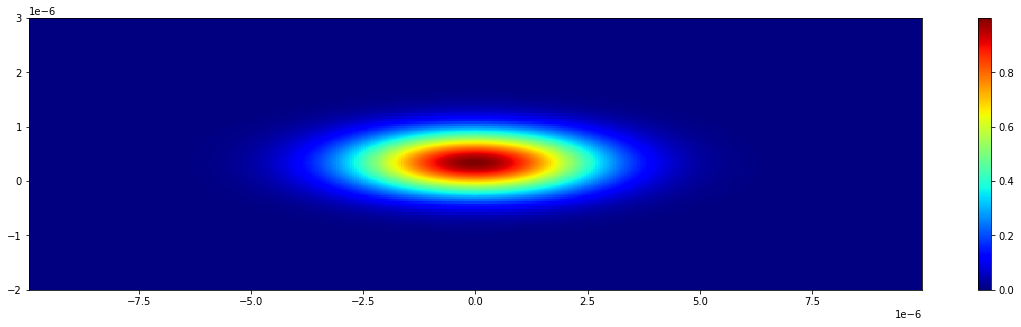

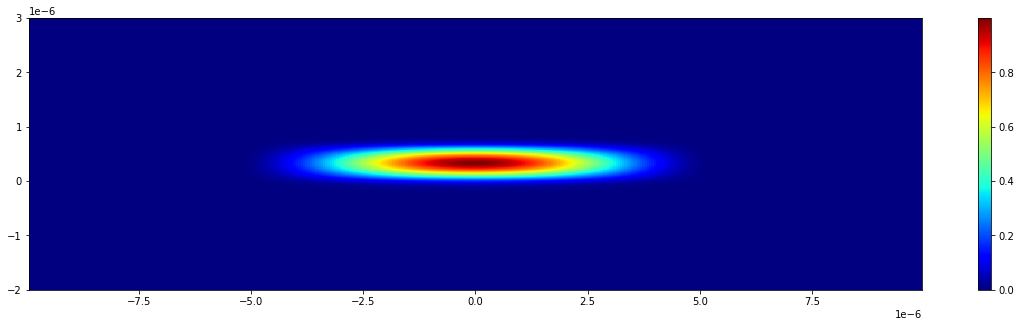

69.33664872124454

In [19]:
plotmode(x,y,np.absolute(Elaser)**2)
# plotmode(x,y,ExWG)
plotmode(x,y,np.transpose(np.absolute(Ex)**2))
overlap(Ex,Elaser,x,y)*100

# Plot Laser mode and Regular WG Mode

In [24]:
for xn,yn in zip(wxls,wyls):
    Elaser = gaussian(x,y,xn,yn,0,0,0)
    print(overlap(Ex,Elaser,x,y))

0.24858486153471324
0.23305557913380634
0.2197016141505787
0.2182590304448671
0.19424821617878724
0.4793305704207316
0.21533040197415107
0.18495252894934971
0.3729085100132071
0.30319894581198065
0.2777411068287382
0.40417136506242196
0.3540709102585191
0.30514695048192014
0.2777411068287382
0.2777411068287382
0.1755589332085395
0.18933921669765152
0.24718681625316644


In [21]:
# Input of Laser beam waist dimensions
wyl = 8.0E-07
wxl = 3.8E-06

# Create a gaussian Ex-field of the laser (Fundamental TE)
Elaser = gaussian(x,y,wxl,wyl,0,0,0)

In [22]:
M = getWGModeAtWidth(width)
Ex = M.E.x
x = M.E.xx
y = M.E.yy

In [9]:
yoff_opt = findWGModeYoff()
Elaser = gaussian(x,y,wxl,wyl,0,yoff_opt,0)
ExWG = gaussian(x,y,wxo,wy_avg,0,yoff_opt,0)

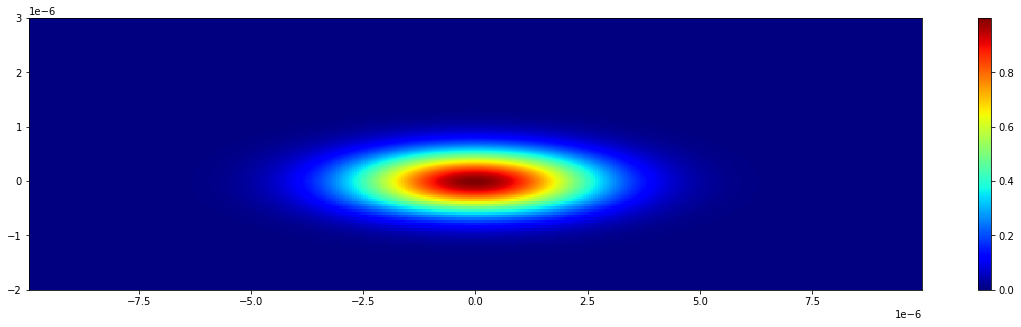

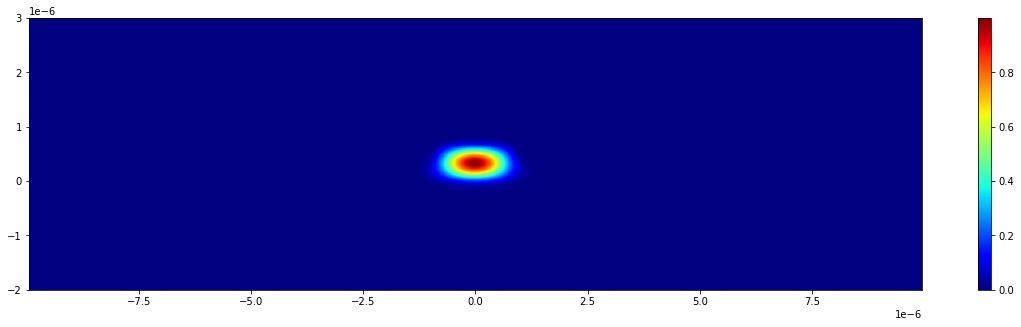

21.533040197415062

In [42]:
plotmode(x,y,np.absolute(Elaser)**2)
# plotmode(x,y,ExWG)
plotmode(x,y,np.transpose(np.absolute(Ex)**2))
overlap(Ex,Elaser,x,y)*100

# This is where we can import lasers and get export of width and overlap

In [22]:
# We can for loop through many different laser waists

ExWx = 7.61*um
ExWy = 1.75*um

# Create a gaussian Ex-field of the laser (Fundamental TE)
Elaser = gaussian(x,y,ExWx,ExWy,0,0,0)
findOptimalWGWidth()

[1.0195634134252912e-05, 7.5000000000000044e-06, 0.6672744236397906]

# Here I am scanning to show fixed dimension (y-waist) limits overlap

In [18]:
scanWx = np.linspace(0.25*um,10*um,100)
scanWy = np.linspace(0.25*um,10*um,100)

scanx = []
scany = []

for w in scanWx:
    Elaser = gaussian(x,y,w,ExWy,0,0,0)
    scanx.append(findOptimalWGWidth()[2]*100)
    
for w in scanWy:
    Elaser = gaussian(x,y,ExWx,w,0,0,0)
    scany.append(findOptimalWGWidth()[2]*100)

Note that during the below sweeps, I allow for the adjustment of the waveguide width. By adjusting the width, we find that we can always optimize the mode overlap. However, since we have a fixed waveguide height, we cannot adjust this parameter to optimize the overlap and so we see maxima in the scanning cureve at the height of the waveguide mode. The conclusion from this is that the most important parameter is the diveregence in the y-direction.


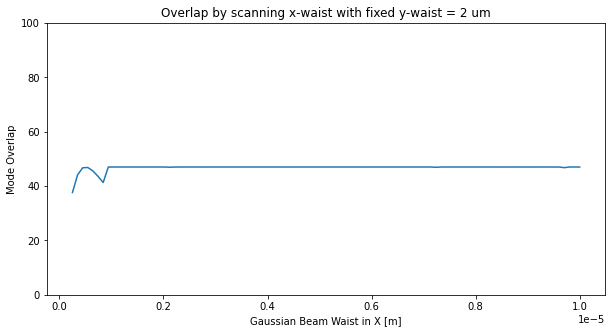

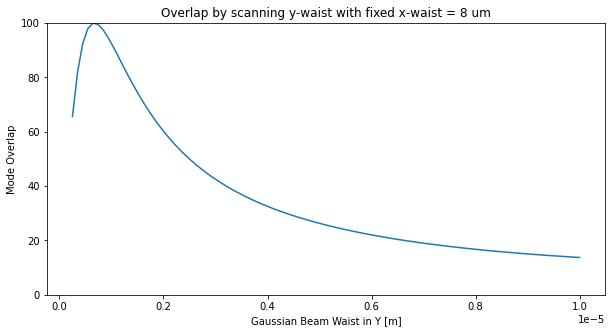

In [19]:
print('Note that during the below sweeps, I allow for the adjustment of the waveguide width. By adjusting the width, we find that we can always optimize the mode overlap. However, since we have a fixed waveguide height, we cannot adjust this parameter to optimize the overlap and so we see maxima in the scanning cureve at the height of the waveguide mode. The conclusion from this is that the most important parameter is the diveregence in the y-direction.')

plt.plot(scanWx, scanx)
plt.rcParams["figure.figsize"] = (10,5) 
plt.xlabel("Gaussian Beam Waist in X [m]")
plt.ylabel("Mode Overlap")
plt.ylim([0,100])
plt.title('Overlap by scanning x-waist with fixed y-waist = 2 um')
plt.show()

plt.plot(scanWy, scany)
plt.rcParams["figure.figsize"] = (10,5) 
plt.xlabel("Gaussian Beam Waist in Y [m]")
plt.ylabel("Mode Overlap")
plt.ylim([0,100])
plt.title('Overlap by scanning y-waist with fixed x-waist = 8 um')
plt.show()

In [11]:
scany[4]

NameError: name 'scany' is not defined